# DC1d modelling and inversion
We want to use direct-current (DC) modelling for 1D layered Earth models.
This is readily implemented in the pyGIMLi (Python Geophysical Modelling and Inversion module).
We make use of the `PyCall` library to call the codes from Julia.

In [2]:
using PyCall
using PyPlot

In [3]:
pg=pyimport("pygimli")

PyObject <module 'pygimli' from 'C:\\Guenther.T\\src\\gimli\\gimli\\pygimli\\__init__.py'>

In [4]:
# We define a AB/2 vector going from 1 to 1000m
ab2 = 10 .^ (0:0.1:3);

In [5]:
# Now we define a 1D DC forward operator, for MN/2 we use AB/2 / 3
number_of_layers = 3
f = pg.core.DC1dModelling(number_of_layers, ab2, ab2/3);

In [6]:
rhoa = f([10, 5, 100, 20, 100]).array();  # two thicknesses, three resistivities

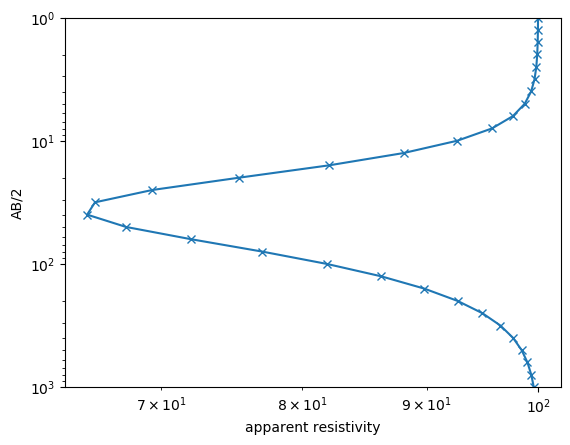

In [7]:
loglog(rhoa, ab2, "x-")
ylim(ab2[end], ab2[1])
xlabel("apparent resistivity")
ylabel("AB/2");

Whereas `DC1dModelling` gets thickness and resistivity values, there is a variant `DC1dRhoModelling` for only resistivity using a predefined thickness vector. This is made for smoothness-constrained inversion.

In [8]:
thkFix = ones(30)
fRho = pg.core.DC1dRhoModelling(thkFix, ab2, ab2/3);

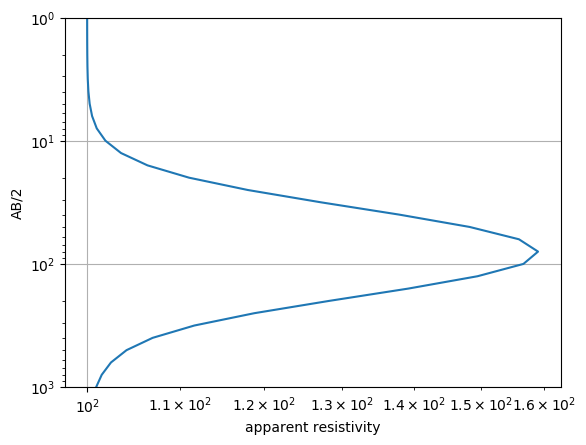

In [9]:
rho = ones(length(thkFix)+1) * 100
rho[20:25] .= 1000
rhoa = fRho(rho).array()
loglog(rhoa, ab2)
grid()
ylim(ab2[end], ab2[1])
xlabel("apparent resistivity")
ylabel("AB/2");

Install the PyCall by calling
```
using Pkg
Pkg.add("PyCall")
```
Make sure pyGIMLi is installed by calling on the Anaconda command line
```
conda install -c gimli -c conda-forge pygimli=1.1
```

## Task 1: functions and jacobian
1. Write a Julia function using the variable-layer forward operator 
1. Write a Julia function using the fixed-layer forward operator 
1. generate a synthetic three-layer model and compute its forward response
1. write a function for computing the Jacobian matrix using the perturbation method
$$ \frac{\partial {\bf f}({\bf m})}{\partial m_j} \approx
\frac{{\bf f}({\bf m} + \delta_j\Delta m )-{\bf f}({\bf m})}{\Delta m} $$
1. Start with a homogeneous resistivity model.
1. compute its Jacobian matrix and display it using matshow

In [10]:
# some function definitions
dc1dblock(model) = f(model).array();
dc1dblock(rho, thk) = dc1dblock(vcat(thk, rho))
dc1dsmooth(model) = fRho(model).array();
function showSounding(rhoa)
    loglog(rhoa, ab2, "x-")
    ylim(maximum(ab2), minimum(ab2));
    grid()
    xlabel("apparent resistivity")
    ylabel("AB/2");
end;

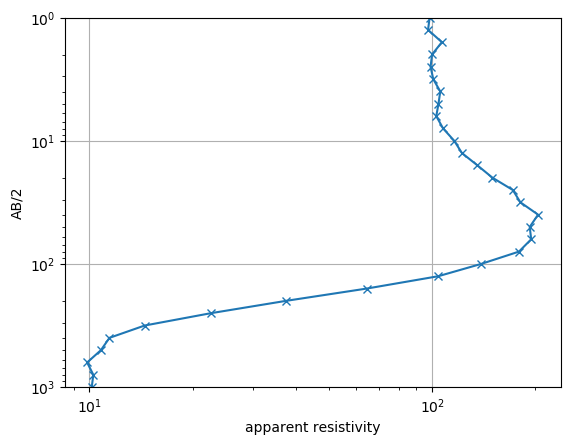

PyObject Text(24.000000000000007, 0.5, 'AB/2')

In [11]:
rho = [100, 1000, 10]  # resistivity vector
thk = [10, 10]
data = dc1dblock(rho, thk)
data = data .* (randn(size(data)) * 0.03 .+ 1.0)
showSounding(data)

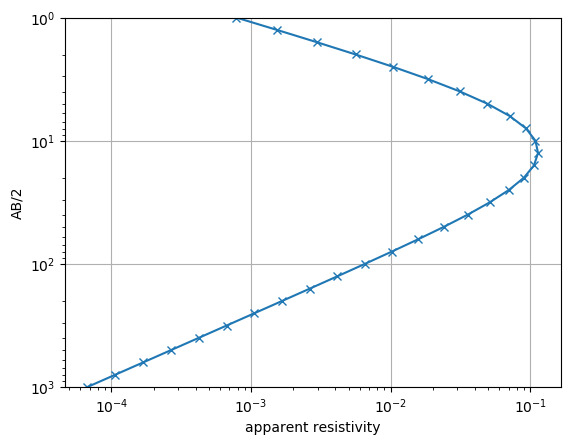

PyObject Text(24.000000000000007, 0.5, 'AB/2')

In [12]:
resistivity = ones(30) * 100  # 100 Ohmm constant
fm = dc1dsmooth(resistivity)  # 100 Ohmm? yes!
resistivity1 = resistivity * 1.0 # make a copy!
i = 5
resistivity1[i] *= 1.1  # change by 10%
fm1 = dc1dsmooth(resistivity1)
sens = (fm1 - fm) ./ (resistivity1[i] - resistivity[i])
showSounding(sens)

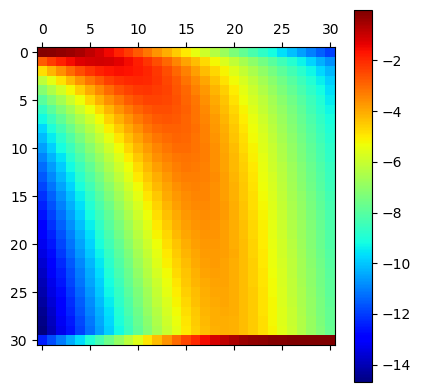

In [13]:
# Now do it for all layers
numlay = fRho.mesh().cellCount()
resistivity = ones(numlay) * 100
fm = dc1dsmooth(resistivity)
S = zeros(length(fm), length(resistivity))
for i = 1:numlay
    resistivity1 = resistivity * 1.0 # make a copy!
    resistivity1[i] *= 1.1  # change by 10%
    fm1 = dc1dsmooth(resistivity1)
    S[:, i] = (fm1 - fm) ./ (resistivity1[i] - resistivity[i])
end
matshow(transpose(log.(S)));
set_cmap("jet")
colorbar();

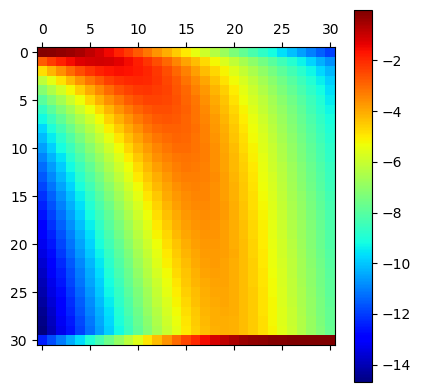

In [14]:
function DC1dSens(resistivity)
    fm = dc1dsmooth(resistivity)
    S = zeros(length(fm), length(resistivity))
    for i = 1:numlay
        resistivity1 = resistivity * 1.0 # make a copy!
        resistivity1[i] *= 1.1  # change by 10%
        fm1 = dc1dsmooth(resistivity1)
        S[:, i] = (fm1 - fm) ./ (resistivity1[i] - resistivity[i])
    end
    return S
end
    
numlay = fRho.mesh().cellCount()
resistivity = ones(numlay) * 100
S = DC1dSens(resistivity)
matshow(transpose(log.(S)));
colorbar();

### Sensitivity for a conductive layer

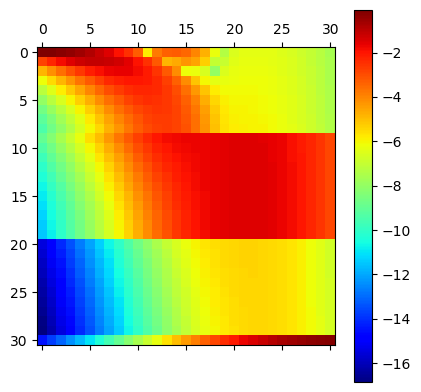

In [21]:
numlay = fRho.mesh().cellCount()
resistivity = ones(numlay) * 100
resistivity[10:20] .= 10
S = DC1dSens(resistivity)
matshow(transpose(log.(abs.(S))));
colorbar();

### Sensitivity for a resistive layer

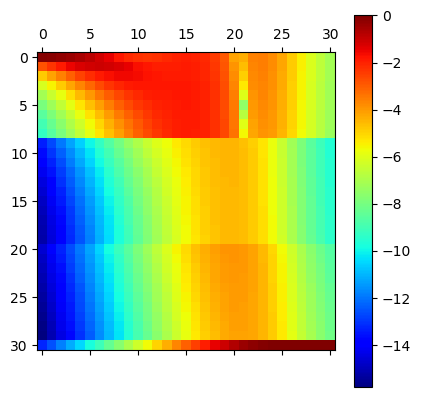

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = show(::IOContext{Base.GenericIOBuffer{Array{UInt8,1}}}, ::MIME{Symbol("text/plain")}, ::PyPlot.LazyHelp) at PyPlot.jl:27
└ @ PyPlot C:\Users\Guenther.T\.julia\packages\PyPlot\XHEG0\src\PyPlot.jl:27


In [22]:
numlay = fRho.mesh().cellCount()
resistivity = ones(numlay) * 100
resistivity[10:20] .= 1000
S = DC1dSens(resistivity)
matshow(transpose(log.(abs.(S))));
colorbar();

### Sensitivity for logarithmic model and data

In [43]:
using LinearAlgebra  # Diagonal
function DC1dSensLog(resistivity)
    fm = dc1dsmooth(resistivity)
    S = DC1dSens(resistivity)
    Slog = Diagonal(1.0 ./ fm) * S * Diagonal(resistivity)
    return Slog
end

numlay = fRho.mesh().cellCount()
resistivity = ones(numlay) * 100
Shom = DC1dSensLog(resistivity)
resistivity[10:20] .= 10
Scond = DC1dSensLog(resistivity)
resistivity[10:20] .= 1000
Sres = DC1dSensLog(resistivity);

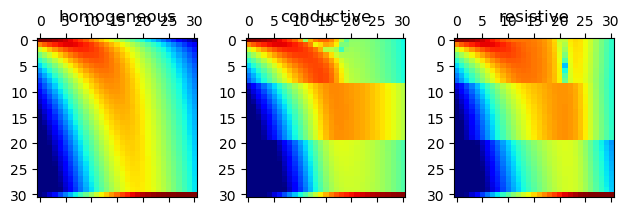

In [42]:
fig, ax = subplots(ncols=3)
ax[1].matshow(transpose(log.(abs.(Shom))), vmin=-12, vmax=0);
ax[1].set_title("homogeneous")
ax[2].matshow(transpose(log.(abs.(Scond))), vmin=-12, vmax=0);
ax[2].set_title("conductive")
ax[3].matshow(transpose(log.(abs.(Sres))), vmin=-12, vmax=0);
ax[3].set_title("resistive");
fig.tight_layout()

## Task 2: Plot the objective function
Generate a three-layer model of which the first and last resistivity model and the thickness of the first layer is assumed constant. Vary the second layer resistivity and thickness over a certain range and plot the resulting objective function $\|d-f(m)\|$  as a matrix.

### Resistive layer

In [ ]:
using LinearAlgebra
rho = [100.0, 1000.0, 100.0]  # resistivity vector (resistive anomaly)
thk = [10.0, 10.0]
data = dc1dblock(rho, thk)
data = data .* (randn(size(data)) * 0.03 .+ 1.0)
rhovals = 10 .^ (2:0.05:4)
thkvals = 10 .^ (0:0.03:1.5)
Phi = zeros(length(rhovals), length(thkvals))
for i = 1:length(rhovals)
    rho[2] = rhovals[i]
    for j = 1:length(thkvals)
        thk[2] = thkvals[j]
        fm = dc1dblock(rho, thk)
        Phi[i, j] = norm(data-fm)
    end
end

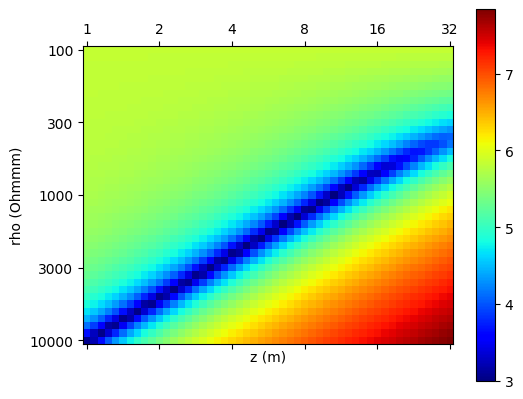

In [70]:
matshow(log.(Phi))
ax = gca()
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_xticklabels(["1", "2", "4", "8", "16", "32"])
xlabel("d (m)")
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_yticklabels(["100", "300", "1000", "3000", "10000"])
ylabel("rho (Ohmmm)")
colorbar();

Obviously, the product of resistivity $\rho$ and thickness $d$ at about 10000 $\Omega m^2$ defines the minimum of the objective function. Equivalent layers have an equal transverse resistance $T=d\cdot \rho$.

### Conductive layer

In [76]:
rho = [100.0, 10.0, 100.0]  # resistivity vector (conductive anomaly)
thk = [10.0, 10.0]
data = dc1dblock(rho, thk)
data = data .* (randn(size(data)) * 0.03 .+ 1.0)
rhovals = 10 .^ (0:0.03:2)
thkvals = 10 .^ (0:0.03:1.6)
Phi = zeros(length(rhovals), length(thkvals))
for i = 1:length(rhovals)
    for j = 1:length(thkvals)
        rho[2] = rhovals[i]
        thk[2] = thkvals[j]
        fm = dc1dblock(rho, thk)
        Phi[i, j] = norm(data-fm)
    end
end

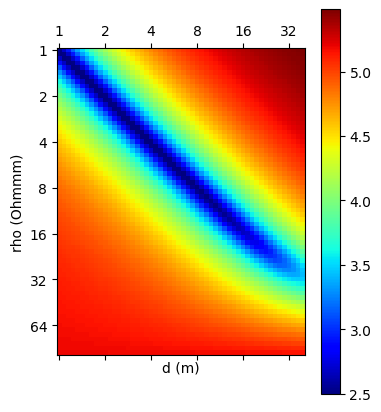

In [82]:
matshow(log.(Phi));
ax = gca()
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_xticklabels(["1", "2", "4", "8", "16", "32"])
xlabel("d (m)")
ax.set_yticks([0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(["1", "2", "4", "8", "16", "32", "64"])
ylabel("rho (Ohmmm)")
colorbar();

On the opposite to the conductive layer, the minimum of the objective function is reached where the ratio of resistivity and thickness is about 1, i.e. the equivalence is for a layer with constant longitudinal conductance $S=d/\rho=d \cdot \sigma$.

## Do a smoothness-constrained inversion
1. Use the sensitivity matrix to compute a new model by Gauss-Newton
2. Use smoothness constraints for regularization
1. Use a line search procedure to determine the step length
1. Optimize the regularization parameter to fit the data within noise
3. Repeat the same with logarithmic model parameters

12.163089800837001

8.254530091124465

6.413821765588793

5.427274180250164

4.841779838192941

4.433905399960928

4.115560698625528

3.8539512632855697

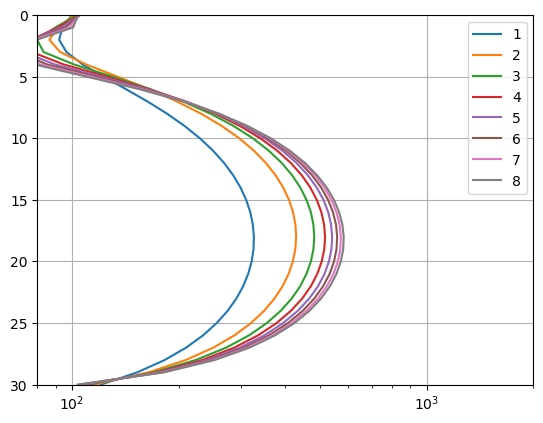

In [84]:
using Statistics
rho = [100.0, 1000.0, 100.0]  # resistivity vector (resistive anomaly)
thk = [10.0, 10.0]
data = dc1dblock(rho, thk)
data = data .* (randn(size(data)) * 0.03 .+ 1.0)
z = cumsum(vcat(0, thkFix))
model = ones(length(z)) * 100
fm = dc1dsmooth(model)
C = zeros(length(thkFix), length(thkFix) + 1)
for i = 1:length(thkFix),
    C[i, i] = -1
    C[i, i+1] = +1
end
lambda = 1
for i = 1:8
    S = DC1dSens(model)
    ST = transpose(S) 
    deltaModel = inv(ST * S .+ transpose(C) * C * lambda) * (ST * (data .- fm))
    model = model + deltaModel  # add line search
    fm = dc1dsmooth(model)
    display(sqrt(mean(((data .- fm)./data).^2)) * 100)
    semilogx(model, z, label=string(i))
end
ylim(maximum(z), minimum(z))
xlim(80, 2000)
grid();
legend();

29.515053713882644

5.572378631871565

3.500411203724866

3.4929881402210103

3.4987676169906

3.4996265426624

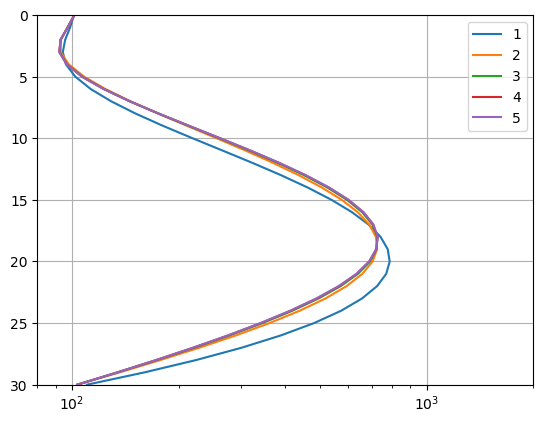

In [101]:
# The same with logarithmic model parameters
model = ones(length(z)) * 100
fm = dc1dsmooth(model)
display(sqrt(mean(((data .- fm)./data).^2)) * 100)
lambda = 0.2
for i = 1:5
    Slog = DC1dSensLog(model)
    deltaData = log.(data) .- log.(fm)
    ST = transpose(Slog)
    CTC = transpose(C) * C
    deltaModel = inv(ST * Slog .+ CTC * lambda) * (ST * deltaData .- CTC * log.(model) * lambda)
    # deltaModel = inv(ST * Slog .+ CTC * lambda) * (ST * deltaData)
    model = model .* exp.(deltaModel)
    fm = dc1dsmooth(model)
    display(sqrt(mean(((data .- fm)./data).^2)) * 100)
    semilogx(model, z, label=string(i))
end
ylim(maximum(z), minimum(z))
xlim(80, 2000)
grid();
legend();

## Block inversion
Perform a block inversion, i.e. using thickness and resistivity values
1. Write a sensitivity function based on dc1dblock that changes all parameters by 10%, using logarithmic parameters. Note that $\log(a*1.1)-\log(a)=\log(a*1.1/a)=\log(1.1)$
1. Try without regularization, and use damping constraints for regularization
1. Use different starting models and show the course of the inversion on top of the objective function for the second-layer thickness and resistivity
1. Increase the noise level
1. Repeat the same with four (or five) layers

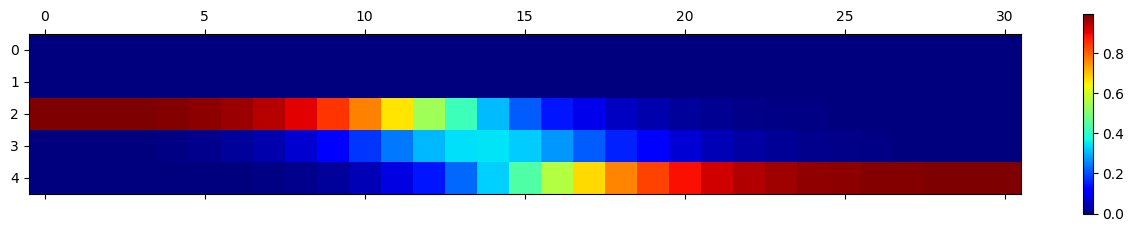

In [102]:
function sens1Dblock(model)
    fm = dc1dblock(model)
    S = zeros(length(fm), length(model))
    for i = 1:length(model)
        model1 = model * 1.0 # make a copy!
        model1[i] *= 1.1  # change by 10%
        fm1 = dc1dblock(model1)
        S[:, i] = (log.(fm1) - log.(fm)) / log(1.1)
    end
    return S
end

model = [6, 6, 100, 100, 100]
S = sens1Dblock(model)
matshow(transpose(S))
colorbar();